In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rcan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

model_number = 3

In [3]:
IN_SHAPE, DELTA = 0, 0
if model_number == 1: 
    IN_SHAPE += 75
    DELTA = config["resolution"]
    seeing = config["seeing_1"]
elif model_number == 2: 
    IN_SHAPE += 64
    DELTA = config["resolution_2"]
    seeing = config["seeing_2"]
else: 
    IN_SHAPE += 64
    DELTA = config["resolution_3"]
    seeing = config["seeing_3"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]

alpha_t_scaling = config["alpha_t_scaling"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]]
alpha_signs = torch.tensor([-1 for _ in range(IN_SHAPE)]+[1 for __ in range(IN_SHAPE)])

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

In [4]:
dataset_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm'],5000)

HR_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub_HR'],5000)
HR_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion_HR'],5000)
HR_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm_HR'],5000)

In [5]:
alpha_model = alpha_model = rcan.RCAN(scale=2, latent_dim=128, num_rg=2, num_rcab=2, reduction=2, out_channels=2).to(device).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25])
alpha_model.load_state_dict(torch.load('Weights_%d.pt'%(model_number), weights_only=True))

<All keys matched successfully>

In [6]:
def give_image(dataset, HR_dataset, alpha_model, length, i=None, plot=False):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)

    if plot:
        plot, axes = plt.subplots(1,4)
        plot.set_size_inches(20,5)
        axes[0].imshow(Image.fromarray(sersic_profile.detach().cpu().numpy()[0]*255))
        axes[1].imshow(Image.fromarray(LR.detach().cpu().numpy()[0]*255))
        axes[2].imshow(Image.fromarray(source_profile.detach().cpu().numpy()[0]*255))
        axes[3].imshow(Image.fromarray(HR_dataset[i].detach().cpu().numpy()[0]*255))
        axes[0].set_title('Lensed')
        axes[1].set_title('LR')
        axes[2].set_title('Source')
        axes[3].set_title('HR')

    return sersic_profile[0].cpu(), LR, source_profile, HR_dataset[i][0].cpu()

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([[1.8259e-09, 3.1500e-09, 4.8538e-09,  ..., 2.9561e-08, 2.1406e-08,
          1.5039e-08],
         [2.8475e-09, 4.2065e-09, 6.3421e-09,  ..., 3.7130e-08, 2.7784e-08,
          2.2070e-08],
         [4.9426e-09, 6.4282e-09, 8.4098e-09,  ..., 4.6343e-08, 3.6556e-08,
          2.9659e-08],
         ...,
         [1.5442e-09, 2.2477e-09, 3.1835e-09,  ..., 2.0115e-08, 1.5805e-08,
          1.2723e-08],
         [5.0821e-10, 1.1417e-09, 2.1551e-09,  ..., 1.5821e-08, 1.1733e-08,
          9.1712e-09],
         [0.0000e+00, 6.1458e-10, 1.4145e-09,  ..., 1.2325e-08, 8.8009e-09,
          5.8962e-09]]),
 tensor([[[0.0018, 0.0021, 0.0019,  ..., 0.0030, 0.0023, 0.0035],
          [0.0028, 0.0025, 0.0016,  ..., 0.0032, 0.0020, 0.0036],
          [0.0028, 0.0026, 0.0028,  ..., 0.0032, 0.0037, 0.0017],
          ...,
          [0.0016, 0.0013, 0.0022,  ..., 0.0025, 0.0040, 0.0031],
          [0.0039, 0.0017, 0.0017,  ..., 0.0024, 0.0031, 0.0019],
          [0.0027, 0.0030, 0.0029,  ..., 0.00

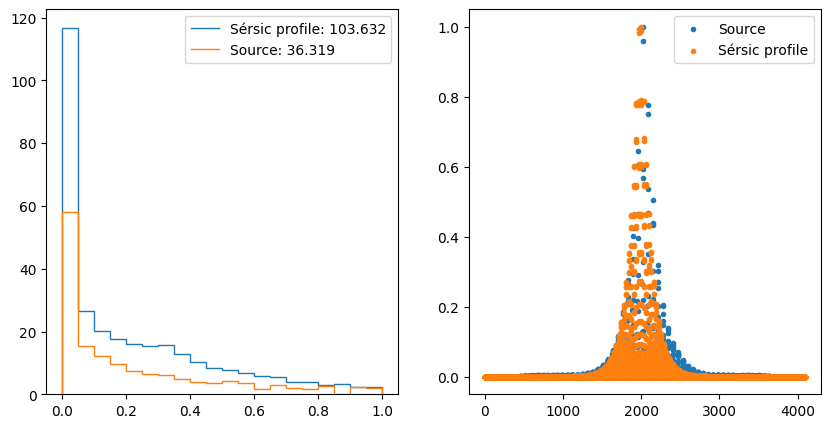

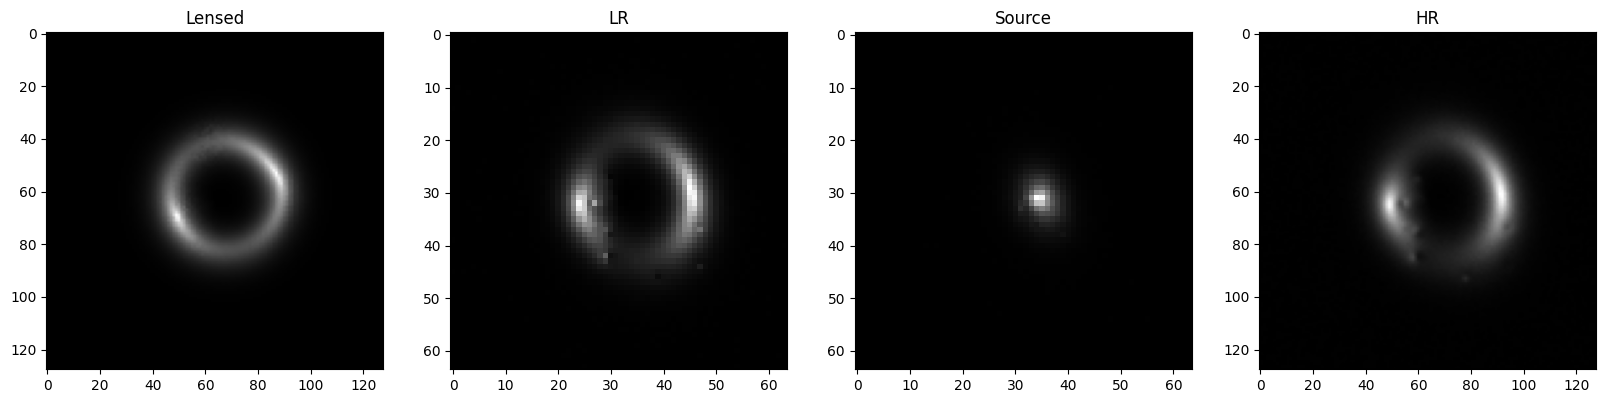

In [7]:
give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_cdm), plot=True)

In [8]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history_no_sub = {'loss':[],'SSIM':[], 'PSNR':[]}
history_axion = {'loss':[],'SSIM':[], 'PSNR':[]}
history_cdm = {'loss':[],'SSIM':[], 'PSNR':[]}

In [9]:
alpha_model.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    image, _, __, HR = give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_cdm['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_cdm['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_cdm['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    image, _, __, HR = give_image(dataset_no_sub, HR_no_sub, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_no_sub['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_no_sub['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_no_sub['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    image, _, __, HR = give_image(dataset_axion, HR_axion, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_axion['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_axion['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_axion['PSNR'].append(PSNR(float(loss)))

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:43<00:00, 115.45it/s]


In [10]:
print(f"no_sub: Evaluation completed with \nMSE: {np.mean(history_no_sub['loss'])} ({np.std(history_no_sub['loss'])})\nSSIM: {np.mean(history_no_sub['SSIM'])} ({np.std(history_no_sub['SSIM'])})\nPSNR:  {np.mean(history_no_sub['PSNR'])} ({np.std(history_no_sub['PSNR'])})")
print(f"axion: Evaluation completed with \nMSE: {np.mean(history_axion['loss'])} ({np.std(history_axion['loss'])})\nSSIM: {np.mean(history_axion['SSIM'])} ({np.std(history_axion['SSIM'])})\nPSNR:  {np.mean(history_axion['PSNR'])} ({np.std(history_axion['PSNR'])})")
print(f"cdm: Evaluation completed with \nMSE: {np.mean(history_cdm['loss'])} ({np.std(history_cdm['loss'])})\nSSIM: {np.mean(history_cdm['SSIM'])} ({np.std(history_cdm['SSIM'])})\nPSNR:  {np.mean(history_cdm['PSNR'])} ({np.std(history_cdm['PSNR'])})")

no_sub: Evaluation completed with 
MSE: 0.003158088934243828 (0.003353868411163028)
SSIM: 0.7865969473939102 (0.04988846167920861)
PSNR:  26.727660921617947 (3.7257836392639367)
axion: Evaluation completed with 
MSE: 0.003097691811584282 (0.0028372508531084874)
SSIM: 0.7786608100643349 (0.045227872110553326)
PSNR:  26.40861047599396 (3.2569977029334485)
cdm: Evaluation completed with 
MSE: 0.003133194220106322 (0.003075224876259331)
SSIM: 0.7793562080364385 (0.04744157983950549)
PSNR:  26.48561756594228 (3.401851780961767)


In [11]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Sub-structure","MSE","SSIM","PSNR"]
table.add_row(["No_substructure","%0.6f"%np.mean(history_no_sub['loss']),"%0.3f"%np.mean(history_no_sub['SSIM']),"%0.3f"%np.mean(history_no_sub['PSNR'])])
table.add_row(["Axion (vortex)","%0.6f"%np.mean(history_axion['loss']),"%0.3f"%np.mean(history_axion['SSIM']),"%0.3f"%np.mean(history_axion['PSNR'])])
table.add_row(["CDM (sub-halos)","%0.6f"%np.mean(history_cdm['loss']),"%0.3f"%np.mean(history_cdm['SSIM']),"%0.3f"%np.mean(history_cdm['PSNR'])])
print(table)

+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003158 | 0.787 | 26.728 |
|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |
| CDM (sub-halos) | 0.003133 | 0.779 | 26.486 |
+-----------------+----------+-------+--------+


In [12]:
"""
Model 1: (finetune)
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003310 | 0.718 | 25.255 |
|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |
| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.004661 | 0.214 | 23.785 |
|  Axion (vortex) | 0.004555 | 0.215 | 24.064 |
| CDM (sub-halos) | 0.004741 | 0.212 | 23.768 |
+-----------------+----------+-------+--------+

Model 3:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003158 | 0.787 | 26.728 |
|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |
| CDM (sub-halos) | 0.003133 | 0.779 | 26.486 |
+-----------------+----------+-------+--------+
"""

'\nModel 1: (finetune)\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003310 | 0.718 | 25.255 |\n|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |\n| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.004661 | 0.214 | 23.785 |\n|  Axion (vortex) | 0.004555 | 0.215 | 24.064 |\n| CDM (sub-halos) | 0.004741 | 0.212 | 23.768 |\n+-----------------+----------+-------+--------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.004830 | 0.716 | 24.520 |\n|  Axion (vortex) | 0.004879 | 0.706 | 24.657 |\n| CDM (sub-halos) | 0

In [13]:
""" RCAN: 
Model 1:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003756 | 0.759 | 25.607 |
|  Axion (vortex) | 0.003854 | 0.749 | 25.466 |
| CDM (sub-halos) | 0.004006 | 0.740 | 25.215 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003104 | 0.219 | 25.353 |
|  Axion (vortex) | 0.003159 | 0.216 | 25.299 |
| CDM (sub-halos) | 0.003231 | 0.216 | 25.191 |
+-----------------+----------+-------+--------+

Model 3: (retrain)
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003976 | 0.717 | 24.792 |
|  Axion (vortex) | 0.003932 | 0.708 | 24.832 |
| CDM (sub-halos) | 0.004084 | 0.706 | 24.608 |
+-----------------+----------+-------+--------+
"""

' RCAN: \nModel 1:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003756 | 0.759 | 25.607 |\n|  Axion (vortex) | 0.003854 | 0.749 | 25.466 |\n| CDM (sub-halos) | 0.004006 | 0.740 | 25.215 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003104 | 0.219 | 25.353 |\n|  Axion (vortex) | 0.003159 | 0.216 | 25.299 |\n| CDM (sub-halos) | 0.003231 | 0.216 | 25.191 |\n+-----------------+----------+-------+--------+\n\nModel 3: (retrain)\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003976 | 0.717 | 24.792 |\n|  Axion (vortex) | 0.003932 | 0.708 | 24.832 |\n| CDM (sub-halo